Investigating the effect of technical indicators on index prices

## Welcome to my Notebook!
In this report, I aim to investigate the effect of technical indicators on stock price. I will utilise 3 different models to analyse whether they are able to observe any patterns in the indicators.

In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
import talib # Technical Analysis Library
from talib.abstract import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Flatten, GRU # LSTM is a type of RNN
from tensorflow.keras.preprocessing import sequence
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from scikeras.wrappers import KerasClassifier
from tensorflow.random import set_seed
import seaborn as sns
from yellowbrick.regressor import ResidualsPlot, CooksDistance, cooks_distance
from sklearn.model_selection import RepeatedKFold, cross_val_score
from tensorflow.keras.models import * 
from tensorflow.keras.layers import * 
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import tensorflow as tf
import keras

pd.options.mode.chained_assignment = None



In [3]:
#TEST THIS
seed = 42
np.random.seed(seed)

First we load in the data and adjust column names to something more usable

In [2]:
data = pd.read_csv(".\\att.csv")
data = data[["TICKER","PRC","VOL","OPENPRC","ASKHI","BIDLO","DATE"]]

data.columns = ["Symbol", "CloseUSD","Volume","open","high","low","date"]

att = data.drop(["Symbol"],axis = 1)

att["date"] = pd.to_datetime(att["date"],format = "%Y%m%d")

Here are some functions to add the technical indicators we are investigating

In [3]:
def addindicators(data):
    df = data.copy()
    df['logret'] = np.log(df.CloseUSD.pct_change()+1)    
    data["1d"] = (np.exp(df["logret"])-1).shift(-1)
        
    data["OBV"] = talib.OBV(data["CloseUSD"], data["Volume"])
    data["SMA12"] = SMA(data["CloseUSD"], timeperiod=12)
    data["SMA25"] = SMA(data["CloseUSD"], timeperiod=25)
    data["SMA100"] = SMA(data["CloseUSD"], timeperiod=100)
    data["RSI"] = RSI(data["CloseUSD"], timeperiod=14)
    data["MACD"] = MACD(data["CloseUSD"], fastperiod=12, slowperiod=26, signalperiod=9)[0]
    data["aroon"] = AROONOSC(data["high"], data["low"], timeperiod=14)
    data["adx"] = ADX(data["high"], data["low"],data["CloseUSD"], timeperiod=14)
    
    return data

In [4]:
df = addindicators(att)

df.at[len(df)-1,"1d"] = 0

df = df.drop(["date"],axis = 1)

We can inspect the data to identify any interesting patterns. Note the large difference in scale of the Volume and OBV indicators

In [40]:
df.describe()

,CloseUSD,Volume,open,high,low,1d,OBV,SMA12,SMA25,SMA100,RSI,MACD,aroon,adx
count,5287.000000,5.287000e+03,5287.000000,5287.000000,5287.000000,5287.000000,5.287000e+03,5276.000000,5263.000000,5188.000000,5273.000000,5254.000000,5273.000000,5260.000000
mean,32.833213,2.237986e+07,32.838165,33.160242,32.497976,0.000043,1.936921e+08,32.825469,32.818066,32.783519,50.650859,-0.017356,2.194468,22.759249
std,6.608318,1.449685e+07,6.596906,6.680649,6.521158,0.016543,6.555457e+08,6.561701,6.524334,6.335913,11.278634,0.514136,63.215822,8.373954
min,19.340000,1.749000e+06,19.220000,19.500000,18.850000,-0.126612,-1.514167e+09,20.345000,20.777600,22.891300,19.416812,-2.394957,-100.000000,6.175807
25%,27.025000,1.128485e+07,27.025000,27.370000,26.700000,-0.007325,-2.177144e+08,26.965833,26.947000,26.488450,42.778052,-0.272149,-57.142857,16.296567
50%,32.980000,2.098930e+07,32.970000,33.260000,32.690000,0.000306,1.718559e+07,33.022917,33.145600,33.532600,50.376530,0.007614,-7.142857,21.540225
75%,37.475000,2.870865e+07,37.490000,37.830000,37.180000,0.007511,6.366399e+08,37.473542,37.474600,36.718450,58.669599,0.291528,64.285714,27.918211
max,58.500000,1.950827e+08,58.125000,59.000000,57.312500,0.162801,2.154360e+09,57.359375,56.750000,51.833275,85.998587,2.372000,100.000000,56.654668


We notice that the indicators contain several NaN values caused by the indicators requiring historical data that isnt available for the first few rows. 

For example, the simple moving average (SMA) utilises the past N days of data to find an average price, hence SMA100 has 99 rows of NaN.

In [41]:
df.isnull().sum()

CloseUSD     0
Volume       0
open         0
high         0
low          0
1d           0
OBV          0
SMA12       11
SMA25       24
SMA100      99
RSI         14
MACD        33
aroon       14
adx         27
dtype: int64

We can now prepare the data for binary classification. Y's are converted into 0 or 1 depending if the daily change is negative or positive. 

The X's go under KNN imputation to fill the empty value. I chose to use KNN imputation because the patterns between the indicators will provide strong estimates as to what the estimated value should be.

The values are then scaled to normal(0,1) values.

Finally, I conduct PCA to reduce the dimensionality of the dataset. We can observe from the plot in the report that choosing the first 2 componenets is optimal using the elbow method.

In [11]:
Y = df["1d"].apply(lambda x: 1 if (x>0) else 0)
X = df.drop(["1d"],axis = 1)

imputer = KNNImputer(n_neighbors=10)
X = imputer.fit_transform(X)

scaler = StandardScaler()
X = scaler.fit_transform(X)

pca = PCA(n_components=2)
X = pca.fit_transform(X)

Here I append 5 days worth of data into each row to allow the model acces to the previous 5 days worth of data.

In [12]:
#append previous 5 days worth of data in aswell
x = np.empty([len(X),10,])
for i in range(5, len(X)):
    x[i] = X[i-5:i].flatten()

x = np.delete(x, np.s_[0:5], axis=0)
#delete first 5 rows of y
y = Y.tail(-5)
y.reset_index(drop=True, inplace=True)


I chose to use the split 80:10:10 as I wanted to prioritise the amount of training data as this is a complex problem.

In [39]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

This is the MLP model. I am connecting 4 dense layers together using a RELU activation function that concludes with a final 1 neuron output layer using a sigmoid function. Read more about my choices in the report.

In [10]:
model = Sequential(name = "MLP")

model.add(Dense(64, input_shape= (X_train.shape[1],), activation='relu', name= "1st_hidden"))

model.add(Dense(64, activation='relu', name= "2nd_hidden"))

model.add(Dense(64, activation='relu', name= "3rd_hidden"))

model.add(Dense(1, name = 'Output_layer', activation='sigmoid'))

model.compile(loss="binary_crossentropy", optimizer="adam", metrics = ["accuracy","binary_accuracy"])


This CNN model utilises several Conv1D layers (as this is 1d data) with varying dilation rates. I applied padding to all the layers as I didnt want it wrapping around and looking at future data. The dimensionality of the data must be increased to 3D as done below.

In [40]:
X_train = np.expand_dims(X_train, axis=1)
X_test = np.expand_dims(X_test, axis=1)
X_val = np.expand_dims(X_val, axis=1)

In [64]:
model = Sequential(name = "CNN")

model.add(Conv1D(64, kernel_size = 3, padding = "same", activation='relu', input_shape=(np.shape(X_train)[1],np.shape(X_train)[2]), name= "1st_conv"))

for i in [1,2,4]:
    model.add(Conv1D(64, kernel_size = 3, padding = "same", dilation_rate = i, activation='relu', name= "conv_dilation_"+str(i)))

model.add(Dense(1, name = 'Output_layer', activation='sigmoid'))

model.compile(loss="binary_crossentropy", optimizer="adam", metrics = ["accuracy","binary_accuracy"])

Reshape the X data to utilise LSTM long term memory

In [17]:
X_train = X_train.reshape(len(X_train),5,2)
X_test = X_test.reshape(len(X_test),5,2)
X_val = X_val.reshape(len(X_val),5,2)

This RNN model uses several LSTM and GRU layers followed by dropouts to maintain generalisability. 

In [18]:
model= Sequential(name = "RNN")

model.add(LSTM(units=100,return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(Dropout(rate=0.2))

model.add(GRU(units=100,return_sequences=True))
model.add(Dropout(rate=0.2))

model.add(LSTM(units=100,return_sequences=True))
model.add(Dropout(rate=0.2))

model.add(GRU(units=100,return_sequences=True))
model.add(Dropout(rate=0.2))

model.add(LSTM(units=100,return_sequences=True))
model.add(Dropout(rate=0.2))

model.add(GRU(units=100,return_sequences=True))
model.add(Dropout(rate=0.2))

model.add(Flatten())
model.add(Dense(1, activation='tanh'))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=["accuracy","binary_accuracy"])

Here are the tools to summarise, fit and evaluate the models

In [50]:
model.build(X_train.shape)
model.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 1st_conv (Conv1D)           (None, 1, 64)             1984      
                                                                 
 conv_dilation_1 (Conv1D)    (None, 1, 64)             12352     
                                                                 
 conv_dilation_2 (Conv1D)    (None, 1, 64)             12352     
                                                                 
 conv_dilation_4 (Conv1D)    (None, 1, 64)             12352     
                                                                 
 conv_dilation_8 (Conv1D)    (None, 1, 64)             12352     
                                                                 
 1st_hidden (Dense)          (None, 1, 64)             4160      
                                                                 
 Output_layer (Dense)        (None, 1, 1)              65      

In [55]:
#evaluate accuracy
model.evaluate(X_test, y_test, verbose = 0)

[0.6930485367774963, 0.5094696879386902, 0.5094696879386902]

These graphs demonstrate the Loss and Accuracy of the models over their epochs

In [65]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=64, verbose = 0)

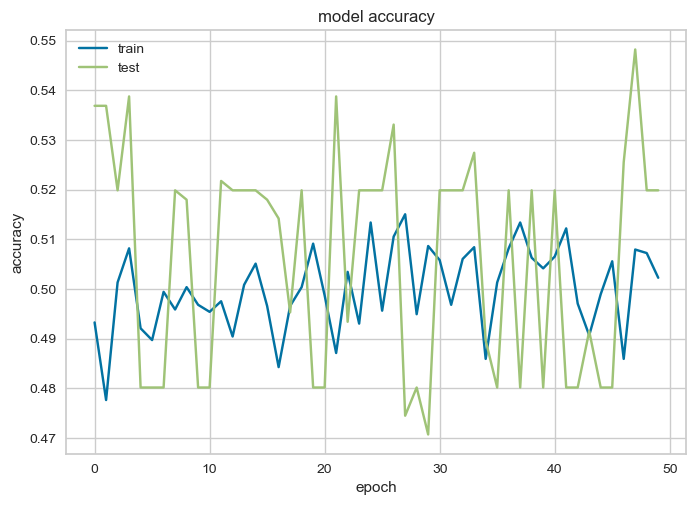

In [ ]:
#plots
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

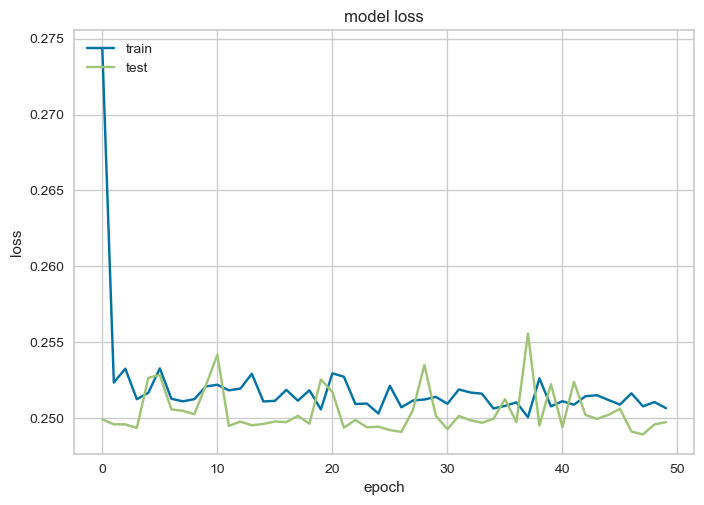

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In this section we conduct grid searching on the models to identify the optimal set of hyperparameters. Be warned this takes a lot of computational power.

The following section is arranged as follows:

A function defining a model with arguments of the hyperparameters. The cell below it contains the code to run the appropriate gridsearch. 

Underneath the 3 gridsearches, there is a function called get_params, use this to discover what parameters can be adjusted

Underneath this are summary tools to identify the results of the gridsearches.

In [9]:
def create_model_MLP(act1,act2,act3,opt,neurons):
    model = Sequential()
    model.add(Dense(neurons, input_shape= (X_train.shape[1],), activation=act1))
    model.add(Dense(neurons, activation=act2))
    model.add(Dense(neurons, activation=act3))
    model.add(Dense(1, activation='sigmoid'))
    # model.compile(loss="binary_crossentropy", optimizer="adam", metrics = ["accuracy","binary_accuracy"])
    model.compile(loss="binary_crossentropy", optimizer = opt, metrics = ["accuracy","binary_accuracy"])
    
    return model


In [10]:
set_seed(42)

model = KerasClassifier(model=create_model_MLP, verbose=0)

batch_size = [32,64]
epochs = [50, 100]
optimizer = ["adam","RMSprop"]
activation = ['relu', 'tanh', 'sigmoid']
neurons = [40,80]


param_grid = dict(batch_size=batch_size, epochs=epochs, model__opt=optimizer, model__act1=activation, model__act2=activation, model__act3=activation, model__neurons=neurons)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

c:\Users\lucia\.conda\envs\data-science\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [67]:
def create_model_CNN(filters,ksize,act1,act2,opt):
    model = Sequential()
    model.add(Conv1D(filters, kernel_size = ksize, padding = "same", activation=act1, input_shape=(np.shape(X_train)[1],np.shape(X_train)[2])))
    for i in [1,2,4]:
        model.add(Conv1D(filters, kernel_size = ksize, padding = "same", dilation_rate = i, activation=act2))

    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss="binary_crossentropy", optimizer=opt, metrics = ["accuracy","binary_accuracy"])

    return model

In [69]:
set_seed(42)

model = KerasClassifier(model=create_model_CNN, verbose=2)

batch_size = [32,64]
epochs = [50, 100]
optimizer = ["adam","RMSprop"]
activation = ['relu', 'tanh', 'sigmoid']
ksize = [3,10]
filters = [10,40]


param_grid = dict(batch_size=batch_size, epochs=epochs, model__opt=optimizer, model__act1=activation, model__act2=activation, model__filters=filters, model__ksize=ksize)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

In [ ]:
def create_model_RNN(opt,rate,units):
    model= Sequential()
    model.add(LSTM(units=units,return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
    model.add(Dropout(rate=rate))
    model.add(GRU(units=units,return_sequences=True))
    model.add(Dropout(rate=rate))
    model.add(LSTM(units=units,return_sequences=True))
    model.add(Dropout(rate=rate))
    model.add(GRU(units=units,return_sequences=True))
    model.add(Dropout(rate=rate))
    model.add(LSTM(units=units,return_sequences=True))
    model.add(Dropout(rate=rate))
    model.add(GRU(units=units,return_sequences=True))
    model.add(Dropout(rate=rate))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=["accuracy","binary_accuracy"])
    
    return model

In [ ]:
set_seed(42)

model = KerasClassifier(model=create_model_RNN(), verbose=0)

batch_size = [32,64]
epochs = [50, 100]
optimizer = ["adam","RMSprop"]
activation = ['relu', 'tanh', 'sigmoid']
dropout_rate = [0.1,0.4]
units = [20,80]



param_grid = dict(batch_size=batch_size, epochs=epochs, model__opt=optimizer, model__rate = dropout_rate, model__units = units)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

In [23]:
print(f"Highest accuracy: {grid_result.best_score_}")
print(f"Best Parameters: {grid_result.best_params_}")

Highest accuracy: 0.5197645479815902
Best Parameters: {'batch_size': 64, 'epochs': 50, 'model__act1': 'relu', 'model__act2': 'relu', 'model__act3': 'tanh', 'model__neurons': 40, 'model__opt': 'adam'}


Finally, we conduct cross validation to truly understand the performance of our optimized models

We will have to rerun the new optimized pre-processing steps

In [ ]:
def addindicators(data):
    df = data.copy()
    df['logret'] = np.log(df.CloseUSD.pct_change()+1)    
    data["1d"] = (np.exp(df["logret"])-1).shift(-1)
        
    data["OBV"] = talib.OBV(data["CloseUSD"], data["Volume"])
    data["SMA12"] = SMA(data["CloseUSD"], timeperiod=12)
    data["SMA25"] = SMA(data["CloseUSD"], timeperiod=25)
    data["RSI"] = RSI(data["CloseUSD"], timeperiod=14)
    data["MACD"] = MACD(data["CloseUSD"], fastperiod=12, slowperiod=26, signalperiod=9)[0]
    
    return data

In [ ]:
df = addindicators(att)

df.at[len(df)-1,"1d"] = 0

df = df.drop(["date"],axis = 1)

In [ ]:
Y = df["1d"].apply(lambda x: 1 if (x>0) else 0)
X = df.drop(["1d"],axis = 1)

imputer = KNNImputer(n_neighbors=10)
X = imputer.fit_transform(X)

scaler = StandardScaler()
X = scaler.fit_transform(X)

pca = PCA(n_components=2)
X = pca.fit_transform(X)

In [ ]:
#append previous 5 days worth of data in aswell
x = np.empty([len(X),10,])
for i in range(5, len(X)):
    x[i] = X[i-5:i].flatten()

x = np.delete(x, np.s_[0:5], axis=0)
#delete first 5 rows of y
y = Y.tail(-5)
y.reset_index(drop=True, inplace=True)


In [ ]:
def create_model_MLP():
    model = Sequential()
    model.add(Dense(40, input_shape= (x.shape[1],), activation="relu"))
    model.add(Dense(40, activation="relu"))
    model.add(Dense(40, activation="tanh"))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss="binary_crossentropy", optimizer = "adam", metrics = ["accuracy","binary_accuracy"])
    
    return model

model = KerasClassifier(model=create_model_MLP, epochs=50, batch_size=64, verbose=0)

In [ ]:
def create_model_CNN():
    model = Sequential()
    model.add(Conv1D(filters, kernel_size = ksize, padding = "same", activation=act1, input_shape=(np.shape(x)[1],np.shape(x)[2])))
    for i in [1,2,4]:
        model.add(Conv1D(filters, kernel_size = ksize, padding = "same", dilation_rate = i, activation=act2))

    model.add(Dense(64, input_shape= (x.shape[1],), activation=act3))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss="binary_crossentropy", optimizer=opt, metrics = ["accuracy","binary_accuracy"])

    return model
    
model = KerasClassifier(model=create_model_CNN, epochs=50, batch_size=64, verbose=0)

In [ ]:
def create_model_RNN():
    model= Sequential()
    model.add(LSTM(units=units,return_sequences=True, input_shape=(x.shape[1],x.shape[2])))
    model.add(Dropout(rate=rate))
    model.add(GRU(units=units,return_sequences=True))
    model.add(Dropout(rate=rate))
    model.add(LSTM(units=units,return_sequences=True))
    model.add(Dropout(rate=rate))
    model.add(GRU(units=units,return_sequences=True))
    model.add(Dropout(rate=rate))
    model.add(LSTM(units=units,return_sequences=True))
    model.add(Dropout(rate=rate))
    model.add(GRU(units=units,return_sequences=True))
    model.add(Dropout(rate=rate))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=["accuracy","binary_accuracy"])
    
    return model
    
model = KerasClassifier(model=create_model_RNN, epochs=50, batch_size=64, verbose=0)

In [ ]:

# model = KerasClassifier(model=create_model, epochs=150, batch_size=10, verbose=0)
# evaluate using 10-fold cross validation
kfold = StratifiedKFold(n_splits=10, shuffle=False, random_state=seed)
results = cross_val_score(model, x, y, cv=kfold)
print(results.mean())